# 1. Overview of Chatbot Personality Analysis

This notebook provides an overview of this research product by describing the research questions, the data gathered, and the analysis conducted. Each research question is addressed in a separate notebook as follow:
  
<code>
1_RQ1_user_experience.ipynb 
2_RQ2_personality_simulation.ipynb 
3_RQ3_user_personality.ipynb 
</code>


# 2. Research Questions

#### RQ1: Does the personality demonstrated by a chatbot affect the user’s experience?

- Which chatbot did the participant prefer? (show counts for each chatbot - bar chart, pie chart, ratio etc.)
    - How does this align with the participant's personality? (correlation between extraversion and preference, agreebleness and preference, can use logistic regression or point biserial correlation)
- Is the preferred chatbot experience positively correlated with conversation engagement metrics such as conversation length? (logistic regression)


#### RQ2: Can Personality be simulated by a chatbot?

- Do participants reliably identify differences between chatbot personality?
- Do participants prefer one chatbot over the other because of its personality?

#### RQ3: Can a user’s personality be inferred through their interaction with a chatbot?

- Do self-described personality traits (beliefs) correlate with interaction metrics (behaviour)?
- Can we use NLP on participant utterances to extract personality traits?
    - How do extracted personality traits correlate with self-described personality traits?


# 3. Data Gathered

Data for this analysis was gathered via an online user study in which participants interacted with two chatbots designed with disctinct personalities. The personalities differ across two factors of the Big 5 Personality Trait model (https://en.wikipedia.org/wiki/Big_Five_personality_traits). These factors are Extroversion (outgoing/energetic vs. solitary/reserved) and Agreeableness (friendly/compassionate vs. challenging/detached). Participants filled out a demographic and personality survey before interacting with the chatbots. After each interaction the participants filled out a survey about how they perceived the chatbot they just used. At the end of the experiment participants filled out a final survey describing which chatbot they preferred. 

# 4. Analysis

We analysis survey responses (text) as well as conversation logs (json). We extract features from the json data including number of conversation turns, average length of user utterances etc. 

### Read in dialog files (JSON)


Each user utterance in a conversation is stored in a separate JSON file which contains fields about the message, the user, and the conversation:

Message:
- type
- ID
- timestamp
- Text

User:
- ID
- Name

Conversation:
- ID

Bot:
- ID
- Name


In [1]:
import json
from pandas.io.json import json_normalize
import os
import logging
import logging.handlers
import pandas as pd
import numpy as np
import glob
from datetime import datetime,timedelta
from collections import Counter
import nltk 
from functools import reduce
import re
from scipy.stats import pointbiserialr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Unpickle Anonymised Data

In [2]:
#unpickle df_dem
df_dem = pd.read_pickle("./df_dem.pkl")
#unpickle df_merged
df_merged = pd.read_pickle("./df_merged.pkl")
#unpickle df_chatbotdata
df_chatbotdata = pd.read_pickle("./df_chatbotdata.pkl")

# Merged Dataframe

df_merged combines the data from all 4 surveys the particiapants completed and the data collected from their interactions with each chatbot

In [3]:
df_merged

Timestamp_x    Age  Gender Do you know what a chatbot is?  \
0   2020/04/11 12:39:37 pm CET  18-24    Male                            Yes   
1    2020/04/11 1:03:11 pm CET  18-24    Male                            Yes   
2   2020/04/11 11:15:03 pm CET  18-24    Male                            Yes   
3    2020/04/12 2:03:09 pm CET  18-24    Male                            Yes   
4   2020/04/15 11:26:28 am CET  18-24    Male                            Yes   
5    2020/04/15 4:51:11 pm CET  18-24    Male                            Yes   
6    2020/04/15 5:01:23 pm CET  18-24    Male                            Yes   
7    2020/04/15 5:22:18 pm CET  18-24    Male                            Yes   
8    2020/04/15 6:16:24 pm CET  35-39  Female                            Yes   
9    2020/04/15 9:39:52 pm CET  18-24    Male                            Yes   
10   2020/04/16 1:38:27 pm CET  18-24    Male                            Yes   
11   2020/04/16 3:03:14 pm CET  18-24  Female                            Yes   
12   2020/04/16 4:03:04 pm CET  18-24  Female                            Yes   
13  2020/04/19 11:37:20 am CET  18-24    Male                            Yes   
14   2020/04/19 1:28:37 pm CET  18-24    Male                            Yes   
15  2020/04/20 11:45:58 am CET  18-24  Female                            Yes   

   If Yes, describe your understanding of what a chatbot is   \
0   software used to 'chat' with a user in-place o...          
1   A computer program that can talk to me in a ch...          
2   A chatbot is an account where a client (user) ...          
3                                     Chat with an AI          
4                                                 NaN          
5   A application or AI that responds to questions...          
6   a software application used to create a chat c...          
7   A program that takes questions  in the form of...          
8   a program that replies usually through text to...          
9   Software the you can have a conversation simil...          
10   Interactive AI designed for online conversations          
11  A piece of software that allows the user to ha...          
12  a computing machine that you can converse with...          
13  Automated tool which will have conversation wi...          
14  a messaging service where you're interacting w...          
15  An online system that you can converse with, i...          

   How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?  \
0                                            Somewhat                                   
1                                            Somewhat                                   
2                                            Somewhat                                   
3                                               Daily                                   
4                                               Daily                                   
5                                            Somewhat                                   
6                                               Daily                                   
7                                            Somewhat                                   
8                                               Never                                   
9                                               Never                                   
10                                              Never                                   
11                                              Never                                   
12                                              Never                                   
13                                              Daily                                   
14                                           Somewhat                                   
15                                              Never                                   

    I am reserved  I tend to find fault with others  \


# Interaction DataFrames

This code parses the json files from the chatbot interactions and stores the data in a dataframe with the following columns:

- Duration (Lenght of conversation in minutes)
- Chatbot (Name of chatbot)
- NumberOfTurns (absolute count of conversation turns made by the participant)
- Utterance (A list of all the participant's utterances)
- Word Count (Total word count of all the participant's utterances (sum))
- Average Utterance Length (The average character length of the participant's utteranes (mean))



In [4]:
df_chatbotdata

Duration     Chatbot  NumberOfTurns  \
0  00:02:00  Nasoto-Bot             10   
1  00:03:00  Nasoto-Bot             20   
2  00:05:00  Nasoto-Bot             19   
3  00:07:00  Nasoto-Bot             19   
4  00:21:00  Nasoto-Bot             34   
5  00:04:00  Nasoto-Bot             23   
6  00:08:00  Nasoto-Bot             20   
7  00:05:00  Nasoto-Bot             19   
8  00:06:00  Nasoto-Bot             27   
9  00:10:00  Nasoto-Bot             14   
10 00:08:00  Nasoto-Bot             24   
11 00:06:00  Nasoto-Bot             14   
12 00:06:00  Nasoto-Bot             22   
13 00:05:00  Nasoto-Bot             13   
14 00:05:00  Nasoto-Bot             19   
15 00:04:00  Nasoto-Bot             30   
16 00:03:00  Nasoto-Bot             18   
0  00:03:00  Makoto-Bot             24   
1  00:01:00  Makoto-Bot              9   
2  00:03:00  Makoto-Bot             16   
3  00:05:00  Makoto-Bot             19   
4  00:01:00  Makoto-Bot              9   
5  00:06:00  Makoto-Bot             21   
6  00:04:00  Makoto-Bot             24   
7  00:05:00  Makoto-Bot             17   
8  00:01:00  Makoto-Bot             10   
9  00:04:00  Makoto-Bot             20   
10 00:03:00  Makoto-Bot             16   
11 00:06:00  Makoto-Bot             21   
12 00:05:00  Makoto-Bot             16   
13 00:01:00  Makoto-Bot              9   
14 00:01:00  Makoto-Bot              9   
15 00:03:00  Makoto-Bot             16   
16 00:02:00  Makoto-Bot              9   

                                            Utterance  Word_Count  Avg_Utt_Len  
0   [our work is compared to master students and p...          33    15.300000  
1   [There is a lot of work in the learning journa...          53    11.400000  
2   [No, Felt it was the right thing to do, Campus...          64    13.000000  
3   [4, my name is mohamed, It was a very necessar...         104    25.105263  
4   [My least favourite is probably Connectionist ...         281    37.558824  
5   [Ethical hacking, unable to access campus, esp...          98    22.217391  
6   [Not bad. I won't really know though, Can I as...          72    15.250000  
7   [this semester, they seem to be involved with ...         108    25.684211  
8   [I like the vast majority of them!, I don't li...         162    26.074074  
9   [A lot of real life application, Rahul, 4, Spa...          24     7.357143  
10  [I would use some fairly often, They're good, ...         107    18.500000  
11  [no, 6, human computer interaction, they are m...          67    23.285714  
12  [ucd campus, the lectures are quite confusing,...         102    23.045455  
13  [Hi, 6, advanced data analytics, i like the gr...          47    16.384615  
14  [UCD campus, I use the library often, No, ok, ...          87    20.105263  
15  [A few i said, 4, Yes, Boring and repetitive, ...          76     9.833333  
16  [it is badly explained, the labs are too hard ...          73    18.666667  
0   [4, ok, Gav, can't go to the library anymore, ...          56    11.416667  
1   [Hi, Its Practical, 5, yes, nope, Generally al...          14     6.777778  
2   [5, campus, interesting topic and a good balan...          37    12.875000  
3   [The content is very interesting and relevant,...          89    22.105263  
4   [human computer interaction, they're nice, 6, ...          20    11.444444  
5   [yes, Órla, 5, They're all terrible, ok, Game ...          63    12.761905  
6   [No, Spatial info systems, No, Yes, I like it,...          44     8.750000  
7   [Probably deep learning, sure, Yes, I use the ...         114    30.176471  
8   [its easy becasue of there only being one form...          37    15.500000  
9   [I'm working from home with my internship, Def...         112    23.950000  
10  [it has made things quite difficult, Human com...          46    13.500000  
11  [mostly positive, yes, yes, I feel it is a nec...         149    28.714286  
12  [5, Alot of my time is spent working, but I en...         124    33.000000  
13  [4, Yes, Very laz

# Demographic Dataframe
This data was collected from the Pre-Interaction survey taken by the participants.
The data has been anonymised, and stored in a dataframe with the following columns:

- Timestamp (The time they began taking the survey)
- Age 
- Gender
- Do you know what a chatbot is? 
- If Yes, describe your understanding of what a chatbot is
- How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?
- Their answers to a range of personality questions 


In [5]:
df_dem

Timestamp    Age  Gender Do you know what a chatbot is?  \
0   2020/04/11 12:39:37 pm CET  18-24    Male                            Yes   
1    2020/04/11 1:03:11 pm CET  18-24    Male                            Yes   
2   2020/04/11 11:15:03 pm CET  18-24    Male                            Yes   
3    2020/04/12 2:03:09 pm CET  18-24    Male                            Yes   
4   2020/04/15 11:26:28 am CET  18-24    Male                            Yes   
5    2020/04/15 4:51:11 pm CET  18-24    Male                            Yes   
6    2020/04/15 5:01:23 pm CET  18-24    Male                            Yes   
7    2020/04/15 5:22:18 pm CET  18-24    Male                            Yes   
8    2020/04/15 6:16:24 pm CET  35-39  Female                            Yes   
9    2020/04/15 9:39:52 pm CET  18-24    Male                            Yes   
10   2020/04/16 1:38:27 pm CET  18-24    Male                            Yes   
11   2020/04/16 3:03:14 pm CET  18-24  Female                            Yes   
12   2020/04/16 4:03:04 pm CET  18-24  Female                            Yes   
13  2020/04/19 11:37:20 am CET  18-24    Male                            Yes   
14   2020/04/19 1:28:37 pm CET  18-24    Male                            Yes   
15  2020/04/20 11:45:58 am CET  18-24  Female                            Yes   
16   2020/04/20 1:02:15 pm CET  18-24  Female                            Yes   

   If Yes, describe your understanding of what a chatbot is   \
0   software used to 'chat' with a user in-place o...          
1   A computer program that can talk to me in a ch...          
2   A chatbot is an account where a client (user) ...          
3                                     Chat with an AI          
4                                                 NaN          
5   A application or AI that responds to questions...          
6   a software application used to create a chat c...          
7   A program that takes questions  in the form of...          
8   a program that replies usually through text to...          
9   Software the you can have a conversation simil...          
10   Interactive AI designed for online conversations          
11  A piece of software that allows the user to ha...          
12  a computing machine that you can converse with...          
13  Automated tool which will have conversation wi...          
14  a messaging service where you're interacting w...          
15  An online system that you can converse with, i...          
16  It is a chatroom with an automated response th...          

   How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?  \
0                                            Somewhat                                   
1                                            Somewhat                                   
2                                            Somewhat                                   
3                                               Daily                                   
4                                               Daily                                   
5                                            Somewhat                                   
6                                               Daily                                   
7                                            Somewhat                                   
8                                               Never                                   
9                                               Never                                   
10                                              Never                                   
11                                              Never                                   
12                                              Never                                   
13                                              Daily                                   
14                                           Somewhat                                   
15 

# Demographic Visualisations

In [6]:
# Age
fig = px.histogram(df_dem, x="Age")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Age Distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [7]:
fig = px.histogram(df_dem, x="Gender")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Gender distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [8]:
# How often the use a chatbot
fig = px.histogram(df_dem, x='How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Frequency distribution of chatbot usage",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
       xaxis_title = "Frequency of chatbot use",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Personality Assignment

Automation of personality assignment

In [49]:
extraversion = ((6 - df_dem['I am reserved']) 
        + df_dem['I am full of energy'] 
        + df_dem['I generate a lot of enthusiasm '] 
        + (6 - df_dem['I tend to be quiet ']) 
        + df_dem['I have an assertive personality'] 
        + (6 - df_dem['I am sometimes shy, inhibited']) 
        + df_dem['I am outgoing, sociable '])


df_dem["extraversion_score"] = extraversion
df_merged["extraversion_score"] = extraversion
               
               
agreeableness = ((6 - df_dem['I tend to find fault with others']) 
        + df_dem['I am helpful and unselfish with others']
        + (6 - df_dem['I start quarrels with others'] )
        + df_dem['I have a forgiving nature'] 
        + df_dem['I am generally trusting'] 
        + (6 - df_dem['I can be cold and aloof '])
        + df_dem['I am considerate and kind to almost everyone']
        + ( 6 - df_dem['I am sometimes rude to others']) 
        + df_dem['I like to cooperate with others'])
df_dem["agreeableness_score"] = agreeableness

df_merged["agreeableness_score"] = agreeableness


In [79]:
# Personality of Participants 
counts, bins = np.histogram(df_dem['extraversion_score'], bins=range(0, 55, 5))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'Extraversion Score', 'y':'count'})
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Distribution of Participant's Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()


In [80]:
# Personality of Participants 
counts, bins = np.histogram(df_dem['agreeableness_score'], bins=range(0, 55, 5))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'Agreeableness Score', 'y':'count'})
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Distribution of Participant's Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Preferred Chatbot 

# Summary Stats

In [12]:
import plotly.express as px
import plotly.graph_objects as go

In [13]:
# convert duratin to minutes from ns
df_chatbotdata = df_chatbotdata.astype({'Duration': 'timedelta64[m]'})

## Box Plot  Interaction Duration

In [14]:
fig = px.box(df_chatbotdata , "Chatbot", "Duration", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Duration of Interaction in Minutes",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Duration (Minutes)",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Number of Conversation Turns

In [15]:
fig = px.box(df_chatbotdata  , "Chatbot", "NumberOfTurns", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Number of Conversation Turns",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Total Number of Turns",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Word Count

In [16]:
fig = px.box(df_chatbotdata  , "Chatbot", "Word_Count", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Total User Word Count",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Total Number of Words",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Average Utterance Length

In [17]:
fig = px.box(df_chatbotdata  , "Chatbot", "Avg_Utt_Len", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Average Utterance Length (characters)",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Number of Characters",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Correlation Between Ratings and Preferred Chatbot

## Knowledge

In [18]:
s = df_merged["How would you rate your interaction/experience with Nasoto based on its knowledge?"].value_counts()
new = pd.DataFrame({'FuncGroup':s.index, 'Count':s.values})  


fig = px.bar(new, x='FuncGroup', y='Count')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings of Nasoto based on its Knowledge",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    xaxis_title = "Ratings (1 = poor, 5 = exceptional) ",
    yaxis_title = "Number of Participants",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()


In [19]:


s = df_merged["How would you rate your experience with Makoto based on its knowledge?"].value_counts()
new = pd.DataFrame({'FuncGroup':s.index, 'Count':s.values})  


fig = px.bar(new, x='FuncGroup', y='Count')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings of Makoto based on its Knowledge",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
  
    xaxis_title = "Ratings (1 = poor, 5 = exceptional) ",
    yaxis_title = "Number of Participants",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.update_traces(marker_color='indianred')
fig.show()



In [20]:
# rating for Knowledge
knowledgeRateNasoto = df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?']
knowledgeRateMakoto = df_merged['How would you rate your experience with Makoto based on its knowledge?'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.4306443375391641, pvalue=0.09587660518017677)
PointbiserialrResult(correlation=-0.49543369430686224, pvalue=0.05100748080923897)


## Attitude/Personality

In [21]:
s = df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"].value_counts()
new = pd.DataFrame({'FuncGroup':s.index, 'Count':s.values})  


fig = px.bar(new, x='FuncGroup', y='Count')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings of Nasoto based on its Attitude/Personality",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    xaxis_title = "Ratings (1 = poor, 5 = exceptional) ",
    yaxis_title = "Number of Participants",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()




In [22]:

s = df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"].value_counts()
new = pd.DataFrame({'FuncGroup':s.index, 'Count':s.values})  


fig = px.bar(new, x='FuncGroup', y='Count')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings of Makoto based on its Attitude/Personality",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
  
    xaxis_title = "Ratings (1 = poor, 5 = exceptional) ",
    yaxis_title = "Number of Participants",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.update_traces(marker_color='indianred')
fig.show()


In [23]:
# rating for Personality 
personalityRateNasoto = df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"]
personalityRateMakoto = df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, personalityRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, personalityRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.3755873143771008, pvalue=0.15168588967073077)
PointbiserialrResult(correlation=-0.526635431152213, pvalue=0.03609761402557406)


## Quality of Conversation

In [24]:

s = df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"].value_counts()
new = pd.DataFrame({'FuncGroup':s.index, 'Count':s.values})  


fig = px.bar(new, x='FuncGroup', y='Count')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings of Nasoto based on the Quality of the Conversation",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    xaxis_title = "Ratings (1 = poor, 5 = exceptional) ",
    yaxis_title = "Number of Participants",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()


In [25]:

s = df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"].value_counts()
new = pd.DataFrame({'FuncGroup':s.index, 'Count':s.values})  


fig = px.bar(new, x='FuncGroup', y='Count')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings of Makoto based on the Quality of the Conversation",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
  
    xaxis_title = "Ratings (1 = poor, 5 = exceptional) ",
    yaxis_title = "Number of Participants",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.update_traces(marker_color='indianred')
fig.show()

In [26]:
#Rating Quality of Conversation 
qualityRateNasoto = df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"]
qualityRateMakoto = df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, qualityRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, qualityRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.5927108612968625, pvalue=0.015537451110818905)
PointbiserialrResult(correlation=-0.28394629237239133, pvalue=0.2865197293896535)


# User Personality Test 

In [27]:
df_personality = pd.DataFrame()

### using df_merged
df_personality['extraversion_score'] = df_merged['extraversion_score']
df_personality['agreeableness_score']= df_merged['agreeableness_score']
df_personality['average_score'] = (df_merged['extraversion_score'] + df_merged['agreeableness_score'])/2
df_personality['preffered_Chatbot'] = df_merged['Which chatbot did you prefer interacting with?']



In [28]:
#Convert chatbot names to values for statistical analysis
#0 - Makoto 
#1 - Nasoto
df_personality['Chatbot_binary'] = pd.np.where(df_personality.preffered_Chatbot.str.contains("Makoto"), 0, 1)
df_personality



/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



extraversion_score  agreeableness_score  average_score preffered_Chatbot  \
0                   19                   36           27.5            Nasoto   
1                   14                   36           25.0            Makoto   
2                   21                   38           29.5            Makoto   
3                   26                   35           30.5            Makoto   
4                   21                   36           28.5            Nasoto   
5                   24                   36           30.0            Makoto   
6                   19                   30           24.5            Makoto   
7                   25                   38           31.5            Makoto   
8                   18                   27           22.5            Nasoto   
9                   25                   31           28.0            Makoto   
10                  22                   36           29.0            Makoto   
11                  13                   35           24.0            Makoto   
12                  29                   44           36.5            Makoto   
13                  20                   41           30.5            Makoto   
14                  20                   38           29.0            Nasoto   
15                  29                   33           31.0            Nasoto   

    Chatbot_binary  
0                1  
1                0  
2                0  
3                0  
4                1  
5                0  
6                0  
7                0  
8                1  
9                0  
10               0  
11               0  
12               0  
13               0  
14               1  
15               1

# Point Biserial Correlation

In [29]:
chatbot = df_personality['Chatbot_binary']
extraversion_score = df_personality['extraversion_score']
agreeableness_score = df_personality['agreeableness_score']

#pbc of extraversion scores
pbc_extraversion = pointbiserialr(chatbot, extraversion_score)
pbc_agreeableness = pointbiserialr(chatbot, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)


PointbiserialrResult(correlation=-0.024423968581281374, pvalue=0.9284592278600012)
PointbiserialrResult(correlation=-0.2761959313076237, pvalue=0.3004422345638311)


# Preferrences Plot

In [30]:
# scatter plot extraversion v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['extraversion_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Extraversion Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [31]:
# scatter plot agreeableness v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['agreeableness_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Agreeableness Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

#### Get total word count for each chatbot 

In [32]:
total_wc_makoto = df_merged['Word_Count_x'].sum(axis = 0, skipna = True) 
total_wc_nasoto = df_merged['Word_Count_y'].sum(axis = 0, skipna = True)

#### Average word Count 

In [33]:
avgWCMakoto = total_wc_makoto/ len(df_merged.index)
avgWCNasoto = total_wc_nasoto / len(df_merged.index)

In [34]:
total_cc_makoto = df_merged['Avg_Utt_Len_x'].sum(axis = 0, skipna = True) 
total_cc_nasoto = df_merged['Avg_Utt_Len_y'].sum(axis = 0, skipna = True)

avgCCMakoto = total_cc_makoto / len(df_merged.index)
avgCCNasoto = total_cc_nasoto / len(df_merged.index)


In [35]:
df_length =  pd.DataFrame()

df_length['preffered_chatbot'] =  df_merged['Which chatbot did you prefer interacting with?']
df_length['numberofTurnsMakoto'] = df_merged['NumberOfTurns_x']
df_length['numberofTurnsNasoto'] = df_merged['NumberOfTurns_y']
df_length['AvgUttLenMakoto'] = df_merged['Avg_Utt_Len_x']
df_length['AvgUttLenNasoto'] = df_merged['Avg_Utt_Len_y']


In [36]:
# data frame for utterance data 
utterance_data =[['Makoto',total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto],
             ['Nasoto',total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto ]] 

df_utterance = pd.DataFrame(utterance_data, columns = ['Chatbot', 'TotalWordCount', 'AverageNumberWords', 'TotalCharCount' ,'AverageCharCount' ] )
df_utterance

Chatbot  TotalWordCount  AverageNumberWords  TotalCharCount  \
0  Makoto            1485             92.8125      310.101286   
1  Nasoto            1075             67.1875      282.457924   

   AverageCharCount  
0          19.38133  
1          17.65362

#### Plot Word Count 

In [37]:
bins=['wordCount', 'avgWordCount', 'charCount', 'avgCharCount']

fig = go.Figure(data=[
    go.Bar(name='Nasoto', x=bins, y=[total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto]),
    go.Bar(name='Makoto', x=bins, y=[total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto])
])
# Change the bar mode
fig.update_layout(
    barmode='group',
    width=700,
    height=750,
    title={
        'text': "Utterance Analysis",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [38]:
#Conversation turns 

# Adjectives used to describe Nasoto and Makoto

In [39]:
#Using natural languge processing find the adjectives asscoiated with each chatbot
def find_adjective(keyword):
    if (pd.isnull(keyword)):
        return ''
    else:
        tokens = nltk.word_tokenize(keyword.lower())
        tagged = nltk.pos_tag(tokens)
        adjective = [w for w,t in tagged if ("JJ" or "JJR" or"JJS" or "RB" or "RBS" or"RBR") in t]
        if len(adjective) < 1:
            return ''
        else:
            return adjective[0]



#### Adjectives associated with Makoto

In [40]:
makoto_adj =  []
makoto_adj = df_merged['Describe Makoto'].apply(find_adjective)
makoto_adj = makoto_adj.append(df_merged['Expand on your answer (optional).2_x'].apply(find_adjective))
#For preferred chatbot = Makoto

makoto_adj = list(makoto_adj)

#### Adjectives associted with Nasoto

In [41]:
nasoto_adj =  []
nasoto_adj = (df_merged['Describe Nasoto'].apply(find_adjective))
nasoto_adj = nasoto_adj.append(df_merged['Expand on your answer (optional).2_y'].apply(find_adjective))

#For preferred chatbot = Nasoto
nasoto_adj = list(nasoto_adj)

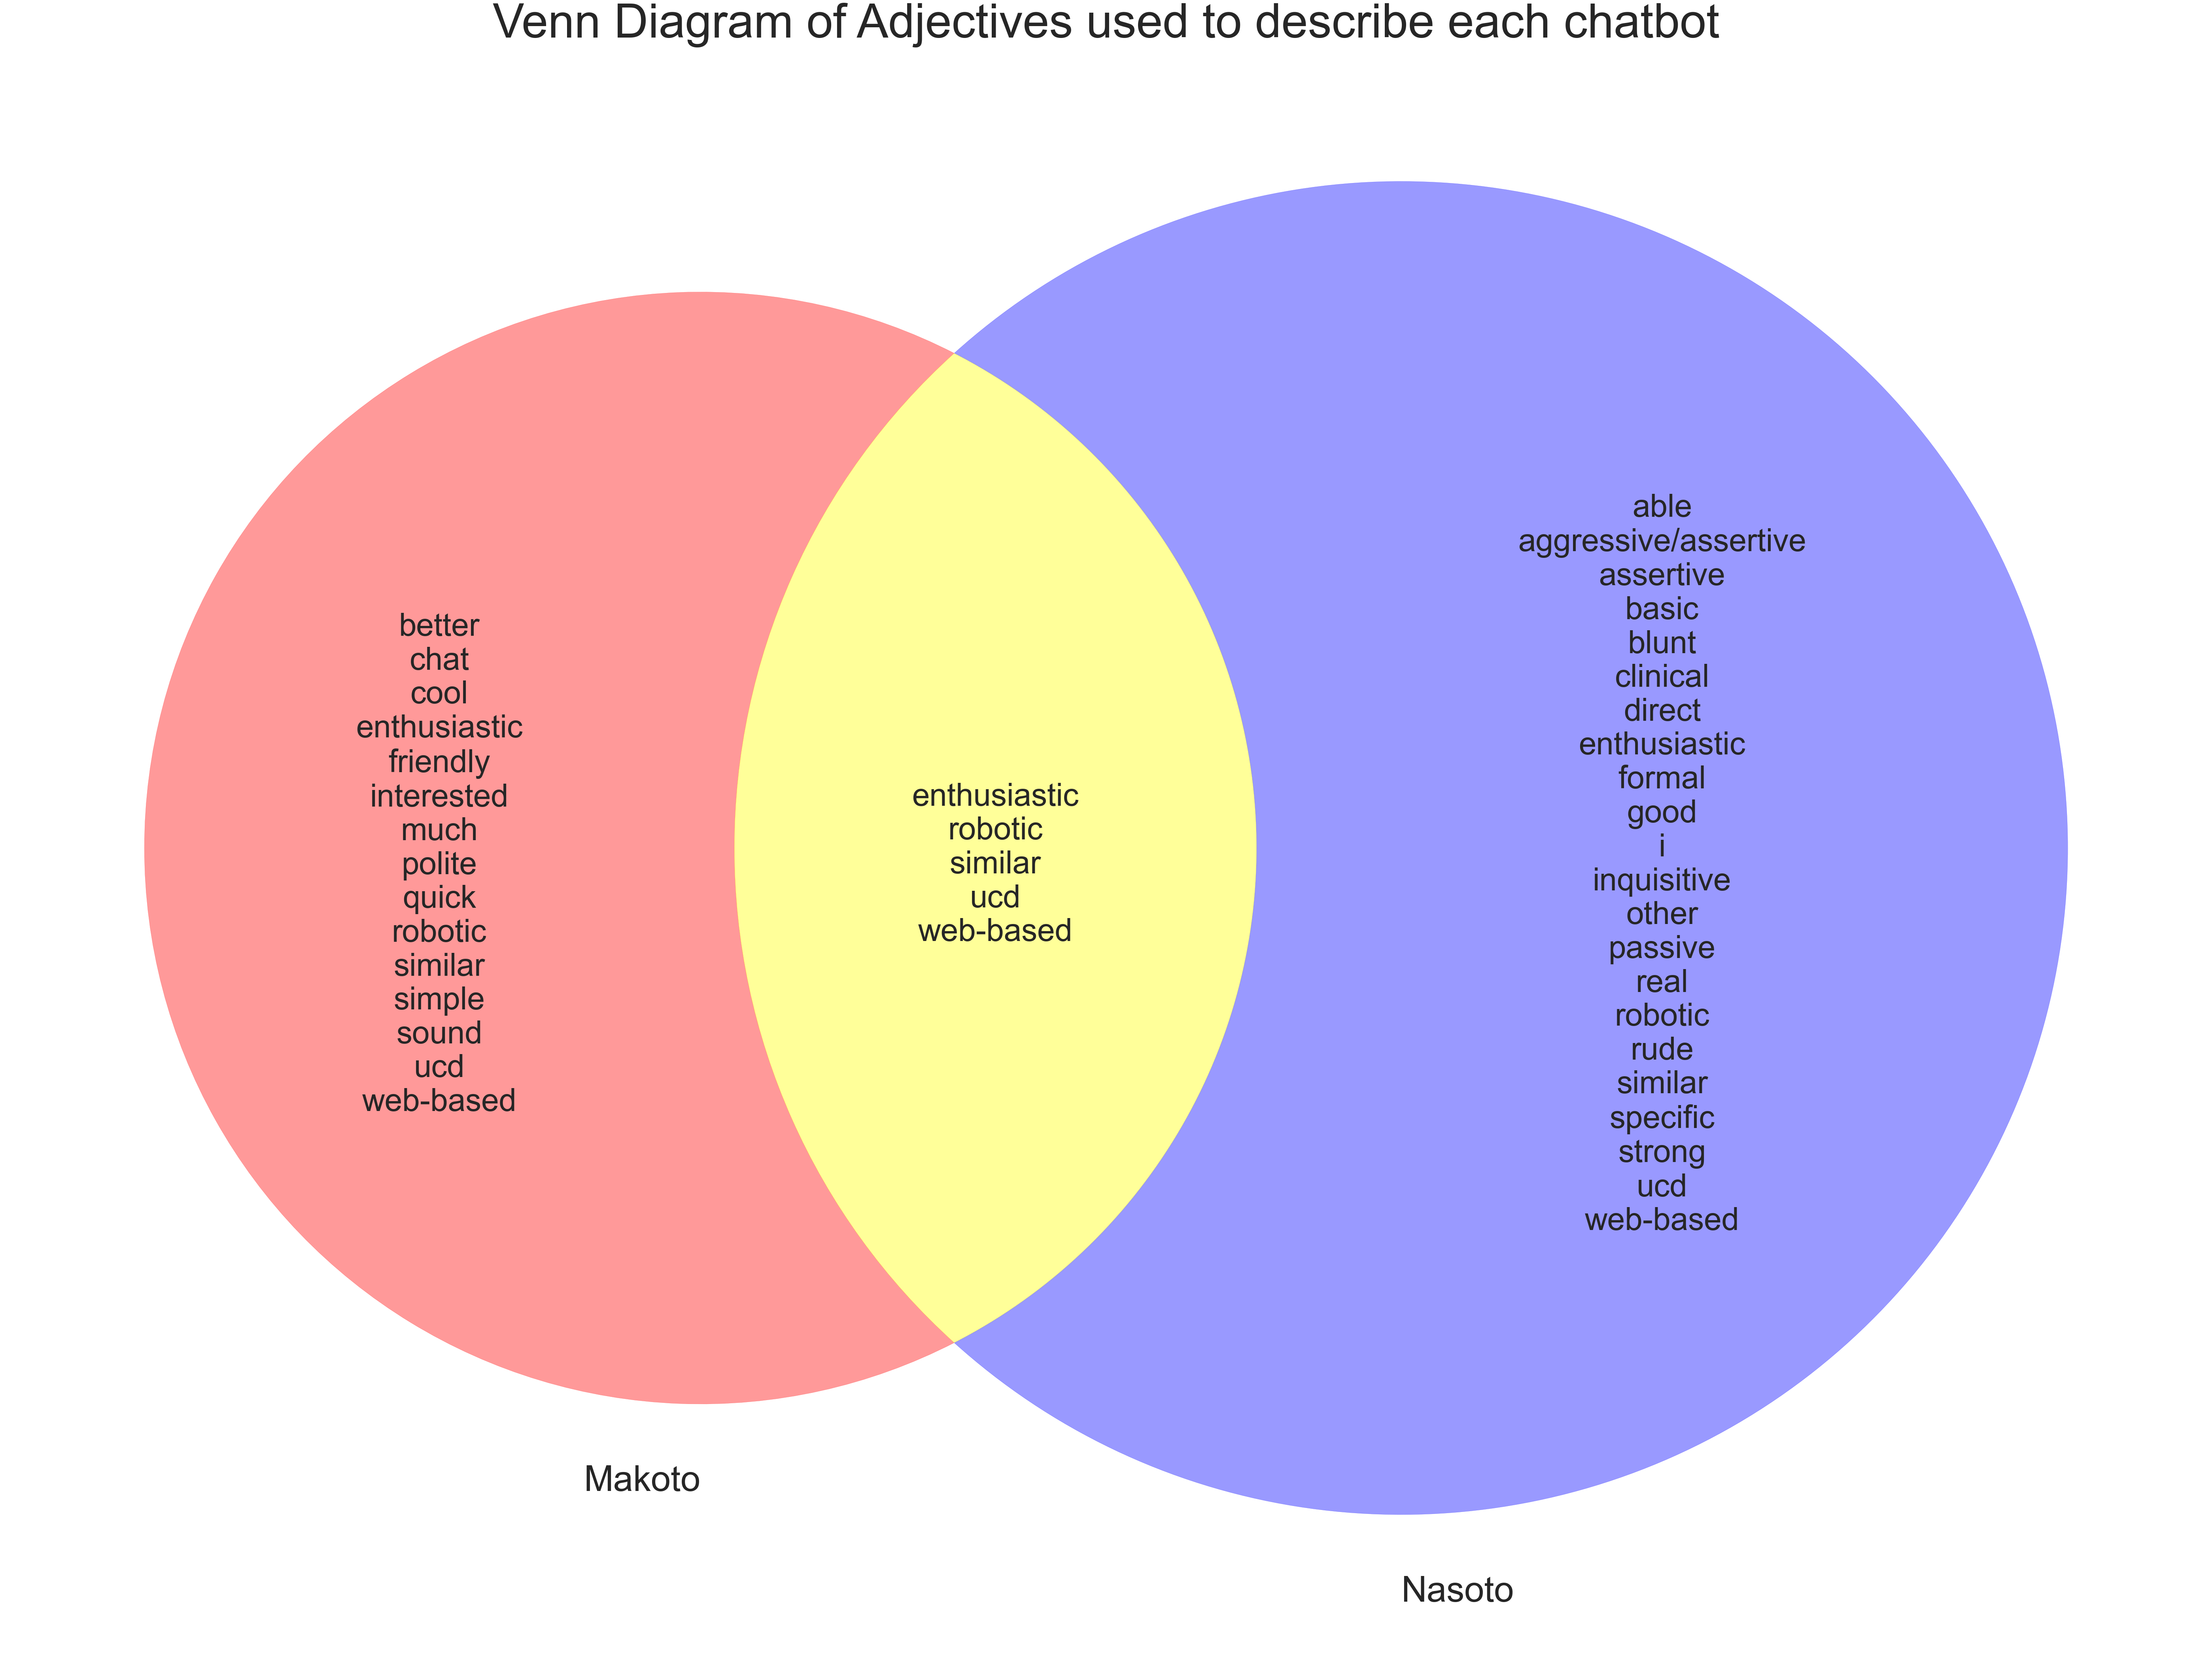

In [42]:
import math
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
plt.figure(figsize=(100, 110))
plt.title('Venn Diagram of Adjectives used to describe each chatbot').set_fontsize(120)
makotoSet = set(makoto_adj)
nasotoSet = set(nasoto_adj)

s = [makotoSet, nasotoSet]
def bits2indices(b):
    l = []
    if b == 0:
        return l
    for i in reversed(range(0, int(math.log(b, 2)) + 1)):
        if b & (1 << i):
            l.append(i)
    return l

# Make dictionary containing venn id's and set intersections
def set2dict(s):
    d = {}
    for i in range(1, 2**len(s)):
        # Make venn id strings
        key = bin(i)[2:].zfill(len(s))
        key = key[::-1]
        ind = bits2indices(i)
        # Get the participating sets for this id
        participating_sets = [s[x] for x in ind] 
        # Get the intersections of those sets
        inter = set.intersection(*participating_sets)
        d[key] = inter
    return d
# Create dictionary from sets
d = set2dict(s)

h = venn2(s, ('Makoto', 'Nasoto'))

for text in h.set_labels:
    text.set_fontsize(90)
h.get_patch_by_id('10').set_color('red')
h.get_patch_by_id('01').set_color('blue')
h.get_patch_by_id('11').set_color('yellow')
for k, v in d.items():
    l = h.get_label_by_id(k)
    if l:
        l.set_text('\n'.join(sorted(v)))
        l.set_fontsize(80)

plt.show()